<h2> Using 4ppm file</h2>
Enough retcor groups, not as many peak insertion problems

In [1]:
import time

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score
#from sklearn.model_selection import StratifiedShuffleSplit
#from sklearn.model_selection import cross_val_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle

from scipy import interp
import scipy.stats as stats

import pickle

# My libraries
import data.preprocessing as preproc
import util.rt_window_prediction as rtwin

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/irockafe/miniconda2/envs/isaac_revo_healthcare/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<h2> Get the xcms feature table </h2>

In [2]:
### Subdivide the data into a feature table
local_path = '/home/irockafe/Dropbox (MIT)/Alm_Lab/projects/'
data_path = local_path + '/revo_healthcare/data/processed/MTBLS315/'\
'uhplc_pos/xcms_result_4.csv'

## Import the data and remove extraneous columns
df = pd.read_csv(data_path, index_col=0)
# convert column names to remove X added to them
new_idx = [i.replace('X', '') for i in df.columns]
df.columns = new_idx
print df.columns
# replace 0 values with nans, so it's easier to replace them later
df = df.replace(to_replace=0.0 , value=np.nan, )

# Make a new index of mz:rt
mz = df.loc[:,"mz"].astype('str')
rt = df.loc[:,"rt"].astype('str')
idx = mz+':'+rt
df.index = idx
df
# separate samples from xcms/camera things to make feature table
not_samples = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 
               'npeaks', 'uhplc_pos', 
               ]
samples_list = df.columns.difference(not_samples)
mz_rt_df = df[not_samples]

# convert to samples x features
X_df_raw = df[samples_list].T

print "original shape: %s \n# nans: %f\n" % (X_df_raw.shape, X_df_raw.isnull().sum().sum())

Index([u'mz', u'mzmin', u'mzmax', u'rt', u'rtmin', u'rtmax', u'npeaks',
       u'uhplc_pos', u'1001_P', u'1002_P', u'1003_P', u'1004_P', u'1005_P',
       u'1006_P', u'1007_P', u'1009_P', u'1010_P', u'1011_P', u'1012_P',
       u'1013_P', u'1014_P', u'1016_P', u'1017_P', u'1018_P', u'1019_P',
       u'1020_P', u'1021_P', u'1023_P', u'1024_P', u'1026_P', u'1027_P',
       u'1029_P', u'1030_P', u'1031_P', u'1032_P', u'1033_P', u'1034_P',
       u'1035_P', u'1036_P', u'1037_P', u'1038_P', u'1039_P', u'1040_P',
       u'1041_P', u'1042_P', u'1043_P', u'1044_P', u'1045_P', u'1046_P',
       u'1048_P', u'1049_P', u'1050_P', u'1051_P', u'1052_P', u'1053_P',
       u'1054_P', u'1055_P', u'1056_P', u'1057_P', u'1058_P', u'1059_P',
       u'1060_P', u'1061_P', u'1062_P', u'1064_P', u'1065_P', u'1066_P',
       u'1067_P', u'1068_P'],
      dtype='object')
original shape: (61, 6737) 
# nans: 3727.000000



<h2> Get mapping between samples names, class names, and file names </h2>

In [3]:
# Get mapping between sample name and assay names
path_sample_name_map = (local_path + 'revo_healthcare/data/raw/' +
                'MTBLS315/metadata/a_UPLC_POS_nmfi_and_bsi_diagnosis.txt')

# Sample name to Assay name
# Index is the sample name
# value we want is the Assay name
sample_df = pd.read_csv(path_sample_name_map, 
                        sep='\t', index_col=0)
sample_df = sample_df['MS Assay Name']
sample_df.shape

# sample name to sample class
path_sample_class_map = (local_path + 'revo_healthcare/data/raw/' +
                        'MTBLS315/metadata/s_NMFI and BSI diagnosis.txt')
class_df = pd.read_csv(path_sample_class_map,
                      sep='\t')
class_df.set_index('Sample Name', inplace=True)
class_df = class_df['Factor Value[patient group]']

# Combine sample > assay and sample > class into one
class_map_df = pd.concat([sample_df, class_df], axis=1)
class_map_df.rename(columns={'Factor Value[patient group]': 'class'}, inplace=True)

# convert all non-malarial classes into a single classes 
# (collapse non-malarial febril illness and bacteremia together)
binary_class_map = class_map_df.replace(to_replace=['non-malarial febrile illness', 'bacterial bloodstream infection' ], 
                                        value='non-malarial fever')

print "binary class map:\n", binary_class_map.head()

# Get case and control samples in their own dataframes
case_str = 'malaria'
control_str = 'non-malarial fever'
# get that assay names based on class
case_labels = binary_class_map[binary_class_map['class'] == case_str]['MS Assay Name']
control_labels = binary_class_map[binary_class_map['class'] == control_str]['MS Assay Name']
# select the assay names from X_df_raw based on class
case = X_df_raw.loc[case_labels]
control = X_df_raw.loc[control_labels]

print 'case shape: ', case.shape
print 'control shape: ', control.shape

binary class map:
            MS Assay Name               class
Sample Name                                  
MCMA429            1001_P             malaria
MCMA430            1002_P             malaria
MCMA431            1003_P             malaria
MCMA433            1004_P             malaria
MCMA434            1005_P  non-malarial fever
case shape:  (34, 6737)
control shape:  (27, 6737)


In [4]:
# convert classes to numbers
le = preprocessing.LabelEncoder()
le.fit(binary_class_map['class'])
y = le.transform(binary_class_map['class'])
y

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [59]:
# Get 

<h2> Preprocess feature table </h2>
Remove systematic intensity biases between samples. Fill nan values

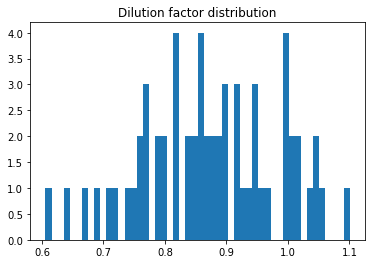

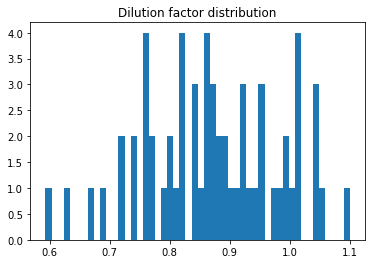

In [5]:
# fill nan values with 1/2 the minimum from each sample
fill_val = X_df_raw.min(axis=1) / 2.0
# must transpose, b/c fillna only operates along columns
X_df_filled = X_df_raw.T.fillna(value=fill_val, ).T

X_pqn_df_raw = preproc.correct_dilution_factor(X_df_raw, plot=True)
X_pqn_df_filled = preproc.correct_dilution_factor(X_df_filled, plot=True)

X_pqn_df_filled_log = np.log10(X_pqn_df_filled)

<h2> Check out the intensity distributions, MW p-vals (warning that
the mw-pvals assume asymptotic normal, so are probably a bit off. Don't rely on them
for important stuff. But as a spot-check, should be okay)

Raw intensities




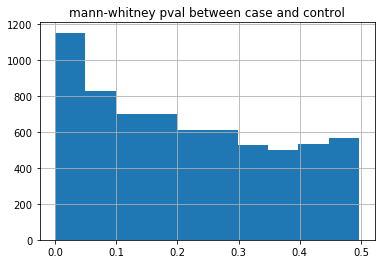

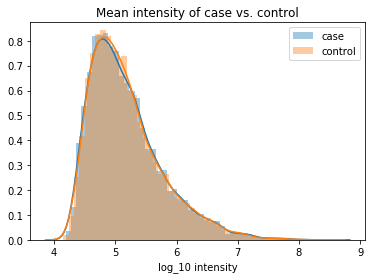

pval (MannW) of intensities between case and control:  0.452020139039
**************************************************
NaN filled with 1/2 min


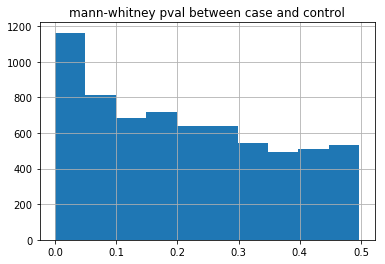

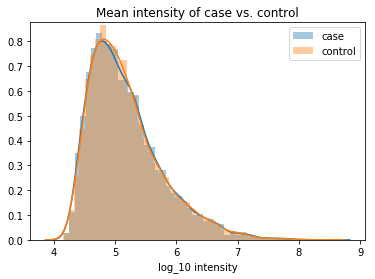

pval (MannW) of intensities between case and control:  0.491113812492
**************************************************
 Raw pqn_normalized


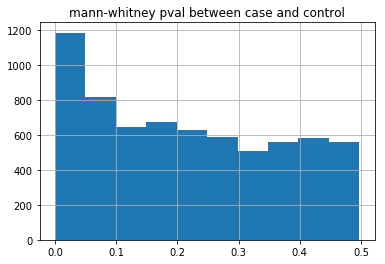

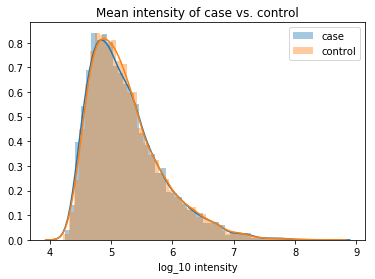

pval (MannW) of intensities between case and control:  0.0799026310394
**************************************************
 NaN filled with 1/2 min, pqn normalized


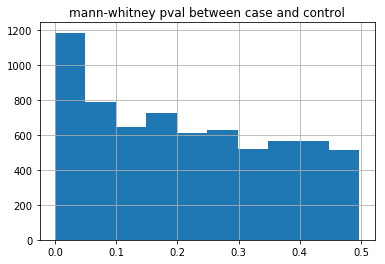

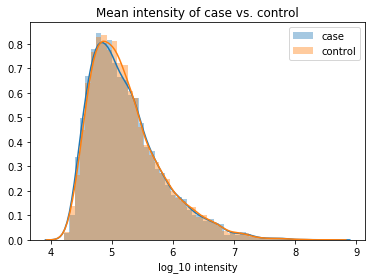

pval (MannW) of intensities between case and control:  0.0831202635868


In [62]:
# Do mann-whitney on case vs control
def mw_pval_dist(case, control):
    '''
    case - dataframe containing case
    control - dataframe with control samples
        All should have same features (columns)
    '''
    # get parametric pvals
    mann_whitney_vals = pd.DataFrame(np.full([case.shape[1],2], np.nan),
                              index=case.columns, columns= ['u', 'pval'])
    for idx, case_vals in case.iteritems():
        control_vals = control[idx]
        u, pval = stats.mannwhitneyu(case_vals, control_vals)
        mann_whitney_vals.loc[idx, 'u'] = u
        mann_whitney_vals.loc[idx, 'pval'] = pval
    
    # plot mw pval distribution
    mann_whitney_vals.hist('pval')
    plt.title('mann-whitney pval between case and control')
    plt.show()
    
    # plot distribution of mean intensities
    case_mean = case.mean(axis=0)
    ctrl_mean = control.mean(axis=0)
    sns.distplot(np.log10(case_mean), label='case')
    sns.distplot(np.log10(ctrl_mean), label='control')
    plt.xlabel('log_10 intensity')
    plt.title('Mean intensity of case vs. control')
    plt.legend()
    plt.show()
    u, pval = stats.mannwhitneyu(case_mean, ctrl_mean)
    print 'pval (MannW) of intensities between case and control: ', pval
    
print('Raw intensities\n\n')
mw_pval_dist(X_df_raw.loc[case_labels], X_df_raw.loc[control_labels])

print('*'*50+'\nNaN filled with 1/2 min')
mw_pval_dist(X_df_filled.loc[case_labels], X_df_filled.loc[control_labels])

print('*'*50+'\n Raw pqn_normalized')
mw_pval_dist(X_pqn_df_raw.loc[case_labels], X_pqn_df_raw.loc[control_labels])

print('*'*50+'\n NaN filled with 1/2 min, pqn normalized')
mw_pval_dist(X_pqn_df_filled.loc[case_labels], X_pqn_df_filled.loc[control_labels])


<h2> Use the raw values - they appear to be closer to the case vals than the dilution-factor normalized values...?

<h2> Run rt-window classifiers and capture the auc distributions
to plot </h2>

RT plot (0.0, 299.13893360513003)
1495.69466803
994.676795832


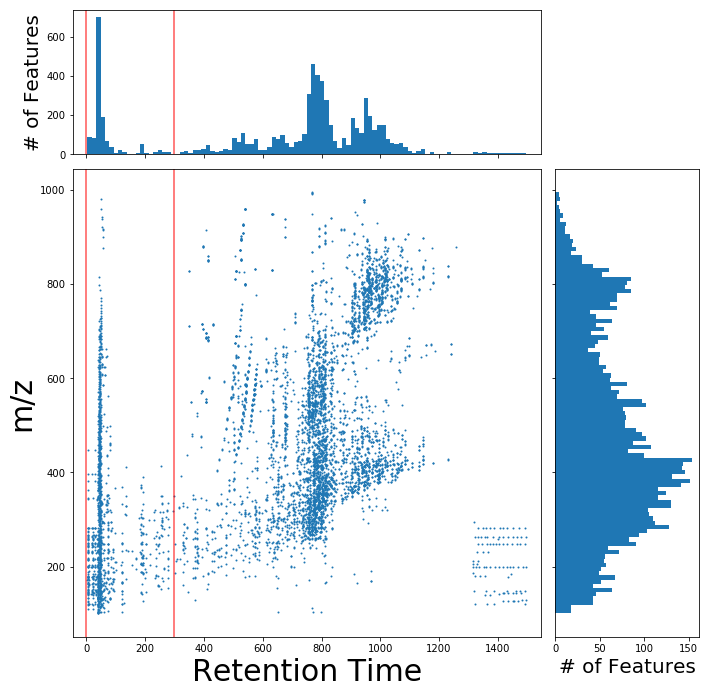

slice shape (61, 1342)
y shape (61,)
0.0% done! 3.3210580349s elapsed
20.0% done! 34.1463060379s elapsed
40.0% done! 70.3792078495s elapsed
60.0% done! 102.011008978s elapsed
80.0% done! 138.818625927s elapsed


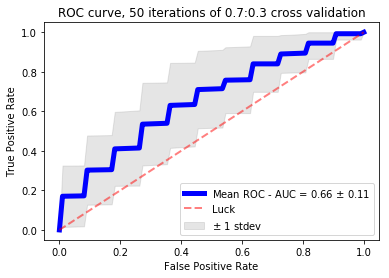




--------------------------------------------------NEXT ROUND--------------------------------------------------



RT plot (149.56946680256502, 448.70840040769508)
1495.69466803
994.676795832


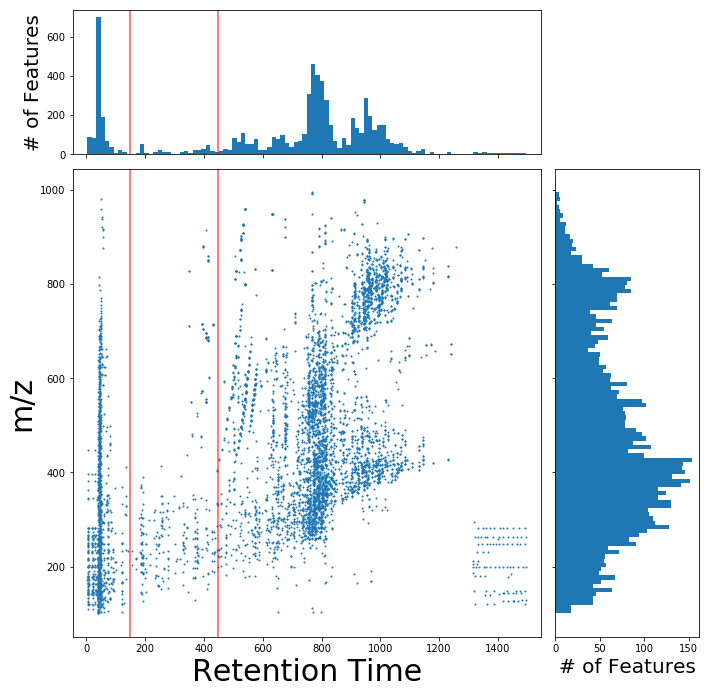

slice shape (61, 311)
y shape (61,)
0.0% done! 4.2364718914s elapsed


KeyboardInterrupt: 

In [10]:
# Add back mz, rt, etc. columns to feature table and reshape it to be
# (feats x samples)
X_df_filled_mzrt = pd.concat([df[not_samples].T, X_pqn_df_filled], 
                                 axis=0).T

# run a sliding windonw
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val / 5
step = width / 2
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)

# run classifier & plot on sliding window
n_iter = 50
test_size = 0.3
rf_trees = 1000
all_aucs = np.full([len(sliding_window), n_iter], np.nan)
path = ('/revo_healthcare/presentations/isaac_bats/'+
                    'rt_window_plots/MTBLS315/')
output_path = local_path + path

# Run rt-sliding-window classifier
rtwin.sliding_rt_window_aucs(X_df_filled_mzrt, y, sliding_window, not_samples,
                      rf_trees=rf_trees, n_iter=n_iter, test_size=test_size,
                      output_path=output_path)

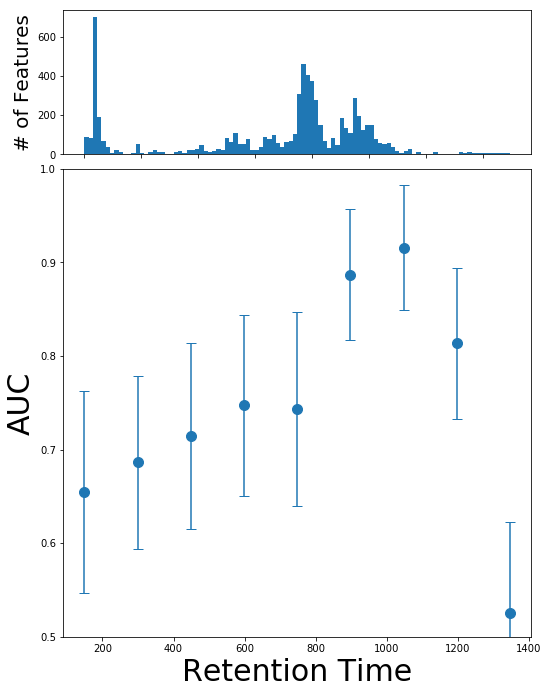

In [223]:
auc_vals = pickle.load(open(output_path+'/auc_vals.pkl', 'rb'))

fig_path = output_path + 'auc_vs_rt.pdf'
rtwin.plot_auc_vs_rt(auc_vals, sliding_window, df, fig_path)

RT plot (0.0, 1495.6946680256501)
1495.69466803
994.676795832


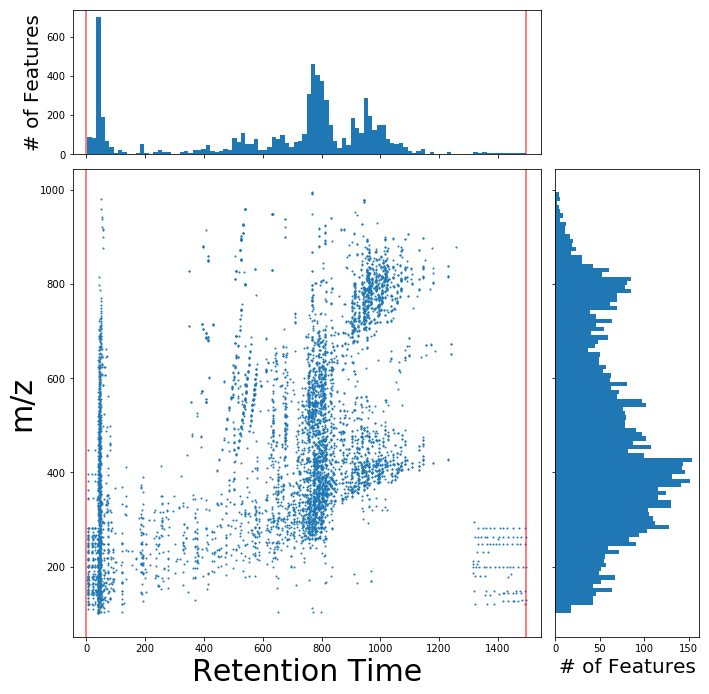

slice shape (61, 6736)
y shape (61,)
0.0% done! 3.85584497452s elapsed
20.0% done! 38.1967251301s elapsed
40.0% done! 70.1910979748s elapsed
60.0% done! 104.331223011s elapsed
80.0% done! 138.373813152s elapsed


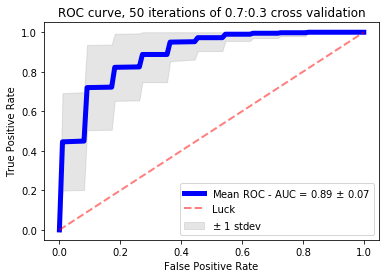




--------------------------------------------------NEXT ROUND--------------------------------------------------





array([[ 0.93181818,  0.95454545,  0.70454545,  0.80681818,  0.90909091,
         0.89772727,  1.        ,  0.81818182,  0.76136364,  0.90909091,
         0.97727273,  0.875     ,  0.90909091,  0.92045455,  0.90909091,
         0.85227273,  0.97159091,  0.89772727,  0.875     ,  0.92045455,
         0.93181818,  0.93181818,  0.73863636,  0.94318182,  0.81818182,
         0.89772727,  0.94318182,  0.77272727,  0.875     ,  0.89772727,
         0.86363636,  0.93181818,  0.96590909,  0.97727273,  0.96590909,
         0.70454545,  0.92045455,  0.875     ,  0.85795455,  0.95454545,
         0.93181818,  0.76704545,  0.94318182,  0.90909091,  0.89772727,
         0.82954545,  0.90909091,  0.93181818,  0.93181818,  0.86363636]])

In [6]:
# Run on whole window
# Add back mz, rt, etc. columns to feature table and reshape it to be
# (feats x samples)
X_df_filled_mzrt = pd.concat([df[not_samples].T, X_pqn_df_filled], 
                                 axis=0).T

# run a sliding windonw
# Make sliding window
min_val = 0
max_val = df['rt'].max()
width = max_val 
step = width 
sliding_window = rtwin.make_sliding_window(min_val, 
                                           max_val, width, step)

# run classifier & plot on sliding window
n_iter = 50
test_size = 0.3
rf_trees = 1000
all_aucs = np.full([len(sliding_window), n_iter], np.nan)
path = ('/revo_healthcare/presentations/isaac_bats/'+
                    'rt_window_plots/MTBLS315/')
output_path = local_path + path

# Run rt-sliding-window classifier
rtwin.sliding_rt_window_aucs(X_df_filled_mzrt, y, sliding_window, not_samples,
                      rf_trees=rf_trees, n_iter=n_iter, test_size=test_size,
                      output_path=output_path)